# Clustering with Spark - Customer Segmentation
In the previous exercise we have tried to get familiar to spark sql and the bills dataset. Now, we want to cluster the clients with respect to their shopping behaviour by using the KMeans algorithm of the Spark ML library.

As before we need to import the needed modules and **create a SparkSession**.

In [16]:
# Import SparkSession
from pyspark.sql import SparkSession

In [17]:
# Create spark object
spark = SparkSession.builder.getOrCreate()

Read the dataframe **bills_exploded_parquet**, which we have created in the previous exercise. Call the dataframe **bills_exploded**. Afterwards, **cache** the dataframe by using the cache method and trigger the caching by applying the count method on the dataframe.

In [18]:
# Create DataFrame bills
bills_exploded = spark.read.parquet('bills_exploded.parquet')
bills_exploded.cache()
print(bills_exploded.count())
bills_exploded.show(5)

18966517
+---------+--------------------+-----+-----------+--------------------+-----+
| category|                name|price| shoppingId|          customerId|total|
+---------+--------------------+-----+-----------+--------------------+-----+
|BACKWAREN|Ciabatta Brötchen...| 3.79|51539607552|7c1e2cc7-8e60-4fe...|58.56|
|BACKWAREN|XXL Hamburger Brö...| 1.19|51539607552|7c1e2cc7-8e60-4fe...|58.56|
|BACKWAREN|Tortilla Wraps We...| 1.55|51539607552|7c1e2cc7-8e60-4fe...|58.56|
|BACKWAREN|Weizenvollkornsan...| 1.45|51539607552|7c1e2cc7-8e60-4fe...|58.56|
|BACKWAREN|  Roggenvollkornbrot| 0.79|51539607552|7c1e2cc7-8e60-4fe...|58.56|
+---------+--------------------+-----+-----------+--------------------+-----+
only showing top 5 rows



In [19]:
# check if df is cached
bills_exploded.is_cached

True

## Feature Engineering

Now, we want to count all products per customerId and category and all prices per customerId and category. Therefore, you can either use the groupBy('column1', 'column2') method followed by the method agg({'columnA': 'functionA', 'columnB': 'functionB'}) or you can register the dataframe bills_exploded as temporary by issuing the command DataFrame.registerTempTable("tableName") and solve the task with spark.sql("SQL-Code"). Finally, rename the columns sum(price) and count(category) to pricePerCategory and itemsPerCategory, respectively, by using the method DataFrame.withColumnRenamed("oldName", "newName"). Please name your final dataframe bills_aggredated.

In [20]:
### Solution 1 ###

bills_aggregated = bills_exploded.groupBy("customerId", "category")\
    .agg({"category": "count", "price": "sum"})\
    .withColumnRenamed("sum(price)", "pricePerCategory")\
    .withColumnRenamed("count(category)", "itemsPerCategory")


### Solution 2 ###

## Registrieren der temporären Tabelle
#billsProducts.registerTempTable(<FILL IN>)
#billsAggregated = sqlContext.sql(<FILL IN>)

# Cachen des Dataframes
bills_aggregated.cache()

# Printen der ersten 20 Einträge
bills_aggregated.show()

+--------------------+--------------------+------------------+----------------+
|          customerId|            category|  pricePerCategory|itemsPerCategory|
+--------------------+--------------------+------------------+----------------+
|523be234-255a-403...|            MOLKE_EI|116.34999999999998|             140|
|713a283e-f319-4c6...|               FISCH|58.150000000000006|              23|
|ae9e8a8f-227a-43b...|           BACKWAREN|            348.62|             224|
|20c36b69-74a3-44e...|            MOLKE_EI|            327.61|             393|
|0aa94d4b-2a1d-42e...|              NUDELN|             313.8|             272|
|b5f690d8-2929-47c...|              NUDELN| 97.15000000000002|              81|
|2003d80e-d84b-4df...|               FETTE|174.00000000000003|             105|
|1e24da6a-df1e-449...|               FETTE|163.61999999999998|              84|
|e7571c85-580c-4e0...|       FLEISCH_WURST|1203.1799999999998|             358|
|e3883334-8a9b-455...|          KAFFEE_T

Next, we want to extract a list of all available categories in the dataframe. Please, select the category column and extract the unique elements. Afterwards, access the underlying rdd attribute of the dataframe, use a flatMap to flatten the rdd elements and apply the collect method to get a list.

In [21]:
# get list of categories to speed up pivot
categoryList = bills_aggregated.select('category').distinct().rdd.flatMap(lambda x: x).collect()

categoryList

['NUDELN',
 'BACKWAREN',
 'GETRAENKE',
 'KAFFEE_TEE',
 'KAESE',
 'FLEISCH_WURST',
 'MOLKE_EI',
 'BROTAUFSTRICH_CEREALIEN',
 'GEWUERZE_BACKZUTATEN',
 'OBST_GEMUESE',
 'FERTIGPRODUKT',
 'FISCH',
 'FETTE',
 'DROGERIEARTIKEL']

The next step is a bit more complicated. We want to transform each category to a column. As the column values we want to use the number of purchased items per customer. Therefore, we can use the **pivot** method. A pivot is an aggregation for which different entries of a grouped column will be transposed into separate columns. This method is very useful for data analysis. If you want to know more abour pivot methods you can find further details here [Pivot-DataBricks](https://databricks.com/blog/2016/02/09/reshaping-data-with-pivot-in-apache-spark.html).

**Remark**: *pivot* can only be applied after a *groupBy*. Afterwards, you have to perform an aggregation, e.g. with *agg*. In our case the sum only contains one element, since for each product category there is only one entry per customerId in the dataframe. We could have combined the pivot and the previous aggregation. Since some customers do not buy products from every category we get null values, which we fill with 0. Finally, we cache the dataframe.
By the way, the previously created list helps us to speed up the execution of the pivot command. 

In [22]:
# Benutzen der Methode Pivot um aus Zeilen Spalten zu machen und eine Aggregation auszuführen
bills_agg_trans = bills_aggregated.groupBy("customerId")\
    .pivot("category").sum("itemsPerCategory")\
    .na.fill(0).cache()

# Printen der ersten zehn Einträge
bills_agg_trans.select("customerId", "BACKWAREN", "MOLKE_EI").show(10)

+--------------------+---------+--------+
|          customerId|BACKWAREN|MOLKE_EI|
+--------------------+---------+--------+
|1a33c8d2-3a40-455...|      107|     140|
|8d96913c-7850-459...|      115|     151|
|0520e94f-f1d4-475...|       97|     165|
|3ecbc3f9-b9b3-4b2...|      401|     379|
|c60362df-146b-424...|      160|     128|
|4b3b63bc-c93b-4e4...|      200|     151|
|73d7da2f-5723-4ac...|      388|     402|
|a0d0061a-754b-40a...|      370|     362|
|d81f3b6f-e695-465...|      175|     141|
|91491da9-d2b3-4b9...|      231|     192|
+--------------------+---------+--------+
only showing top 10 rows



In [23]:
### Elegante Alternative ###
# Lösung, welches den vorherigen Schritt zur Erstellung von billsAggregated direkt beinhaltet.
bills_agg_trans_alt = bills_exploded.groupBy("customerId")\
    .pivot("category").agg({"category": "count"})\
    .na.fill(0).cache()
    
bills_agg_trans_alt.select("customerId", "BACKWAREN", "MOLKE_EI").show(10)

+--------------------+---------+--------+
|          customerId|BACKWAREN|MOLKE_EI|
+--------------------+---------+--------+
|8d96913c-7850-459...|      115|     151|
|1a33c8d2-3a40-455...|      107|     140|
|0520e94f-f1d4-475...|       97|     165|
|3ecbc3f9-b9b3-4b2...|      401|     379|
|c60362df-146b-424...|      160|     128|
|4b3b63bc-c93b-4e4...|      200|     151|
|73d7da2f-5723-4ac...|      388|     402|
|a0d0061a-754b-40a...|      370|     362|
|d81f3b6f-e695-465...|      175|     141|
|91491da9-d2b3-4b9...|      231|     192|
+--------------------+---------+--------+
only showing top 10 rows



Please print the Schema of the bills_agg_trans dataframe.

In [24]:
bills_agg_trans.printSchema()

root
 |-- customerId: string (nullable = true)
 |-- BACKWAREN: long (nullable = true)
 |-- BROTAUFSTRICH_CEREALIEN: long (nullable = true)
 |-- DROGERIEARTIKEL: long (nullable = true)
 |-- FERTIGPRODUKT: long (nullable = true)
 |-- FETTE: long (nullable = true)
 |-- FISCH: long (nullable = true)
 |-- FLEISCH_WURST: long (nullable = true)
 |-- GETRAENKE: long (nullable = true)
 |-- GEWUERZE_BACKZUTATEN: long (nullable = true)
 |-- KAESE: long (nullable = true)
 |-- KAFFEE_TEE: long (nullable = true)
 |-- MOLKE_EI: long (nullable = true)
 |-- NUDELN: long (nullable = true)
 |-- OBST_GEMUESE: long (nullable = true)



Please compute the total price and total number of shoppings per customer. Therefore, you can use the bills_exploded dataframe and the methods groupBy and agg. Please rename the columns total_shoppings and total_price. Afterwards, cache the dataframe and trigger the caching via a count method. The final dataframe should be called shoppings_df.

**Hint**: For the aggregation you can either use agg({...}) followed by withColumnRenamed, or you can use agg(F.sum(column).alias('newName'), F.count()....) to directly rename the column inside the aggregate method.

In [25]:
from pyspark.sql import functions as F

# compute total price and total number of shoppings per customer
shoppings_df = bills_exploded.groupBy("customerId").agg(F.count("customerId").alias('total_shoppings'),
                                             F.sum('total').alias('total_price')).cache()
shoppings_df.count()
shoppings_df.show()

+--------------------+---------------+------------------+
|          customerId|total_shoppings|       total_price|
+--------------------+---------------+------------------+
|d45fd262-c235-4b7...|           3273|180638.58628300036|
|5b81b895-f1cb-436...|           3171| 177349.2561530013|
|0520e94f-f1d4-475...|           1478| 37450.09042400003|
|9916f4f8-b2d9-4aa...|           1251| 21989.24975099998|
|1f2272df-8b64-496...|           3273| 182828.3250620001|
|add40eb1-5431-450...|           1209|     20942.4004777|
|791ba93d-0160-49d...|           1304| 33811.91039799998|
|3ecbc3f9-b9b3-4b2...|           3135| 170084.2796720003|
|81fea2df-6b11-4c2...|           1574|40867.410328999955|
|f6e7aef9-b117-441...|           1375| 35492.23068899997|
|de629931-ae95-4b8...|           1550|38318.510732499984|
|a58bb6d7-38bd-439...|           3298| 178074.6367160001|
|364b91ac-7bf6-481...|           3601|195696.29798499926|
|49cd60a5-c657-4dc...|           1405| 24639.84996550001|
|d33f3466-da3e

Join the shoppings_df dataframe with the bills_agg_trans dataframe by using the join method like df1.join(df2, on='column'). Please joing the two dataframes over the column customerId.

In [26]:
df = shoppings_df.join(bills_agg_trans, on='customerId').cache()
df.count()
df.show(5)

+--------------------+---------------+------------------+---------+-----------------------+---------------+-------------+-----+-----+-------------+---------+--------------------+-----+----------+--------+------+------------+
|          customerId|total_shoppings|       total_price|BACKWAREN|BROTAUFSTRICH_CEREALIEN|DROGERIEARTIKEL|FERTIGPRODUKT|FETTE|FISCH|FLEISCH_WURST|GETRAENKE|GEWUERZE_BACKZUTATEN|KAESE|KAFFEE_TEE|MOLKE_EI|NUDELN|OBST_GEMUESE|
+--------------------+---------------+------------------+---------+-----------------------+---------------+-------------+-----+-----+-------------+---------+--------------------+-----+----------+--------+------+------------+
|d45fd262-c235-4b7...|           3273|180638.58628300036|      402|                    204|            101|          220|   38|  113|          410|      402|                  30|  209|       145|     395|   308|         296|
|5b81b895-f1cb-436...|           3171| 177349.2561530013|      381|                    200|         

In [27]:
df.printSchema()

root
 |-- customerId: string (nullable = true)
 |-- total_shoppings: long (nullable = false)
 |-- total_price: double (nullable = true)
 |-- BACKWAREN: long (nullable = true)
 |-- BROTAUFSTRICH_CEREALIEN: long (nullable = true)
 |-- DROGERIEARTIKEL: long (nullable = true)
 |-- FERTIGPRODUKT: long (nullable = true)
 |-- FETTE: long (nullable = true)
 |-- FISCH: long (nullable = true)
 |-- FLEISCH_WURST: long (nullable = true)
 |-- GETRAENKE: long (nullable = true)
 |-- GEWUERZE_BACKZUTATEN: long (nullable = true)
 |-- KAESE: long (nullable = true)
 |-- KAFFEE_TEE: long (nullable = true)
 |-- MOLKE_EI: long (nullable = true)
 |-- NUDELN: long (nullable = true)
 |-- OBST_GEMUESE: long (nullable = true)



### Feature Extraction and Preparation

Now we have modified our dataset so that we can start with feature extraction and preparation. For the clustering algorithm we want to use all product categories and the total price as features.

Before we proceeed we import the following modules.

In [28]:
# Spark ML
from pyspark.ml.feature import VectorAssembler, Normalizer, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer

# Spark MLlib
from pyspark.mllib.linalg import Vectors, VectorUDT

# Matplotlib, Pandas and Numpy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-pastel')
import numpy as np
import pandas as pd

### Vector Assembler

To combine product category columns to a feature vector we can use the VectorAssembler Class. Please create an object of that class called categoryAssembler. Please set the constructor agument inputCols to the list of all categories, i.e. categoryList, and the outputCol to "productCategoryFeatures".

In [29]:
# combine product category columns
categoryAssembler = VectorAssembler(inputCols=categoryList,
                                  outputCol="productCategoryFeatures")

If you want, you can try out the transform method of the vectorAssembler object. As the input of the method please use the dataframe df. Later on we will combine all feature extraction and preparation steps to a so called machine learning pipeline.

In [30]:
categoryAssembler.transform(df).select('productCategoryFeatures').show()

+-----------------------+
|productCategoryFeatures|
+-----------------------+
|   [308.0,402.0,402....|
|   [302.0,381.0,401....|
|   [96.0,97.0,201.0,...|
|   [205.0,95.0,202.0...|
|   [309.0,402.0,375....|
|   [191.0,95.0,179.0...|
|   [92.0,89.0,172.0,...|
|   [295.0,401.0,378....|
|   [100.0,200.0,200....|
|   [103.0,102.0,193....|
|   [101.0,134.0,222....|
|   [294.0,411.0,411....|
|   [323.0,435.0,443....|
|   [214.0,112.0,221....|
|   [331.0,423.0,434....|
|   [92.0,96.0,183.0,...|
|   [102.0,200.0,204....|
|   [231.0,125.0,264....|
|   [97.0,115.0,210.0...|
|   [217.0,111.0,214....|
+-----------------------+
only showing top 20 rows



In [31]:
### 

### Normalizing the Feature Vector
The generated feature vector contains the total amount of products per category which the customer has bought during all his shoppings. Since KMeans uses distances we would cluster clients which shop more often than others together. However, this is not what we want. We want to normalize the feature vector so that we get the proportion of items per category that a client has bought during all his shoppings. This can be achieved by using a normalizer which applies the L1 norm to our vector.

Example:

Imagine a client has bought 10 Milchprodukte, 5 Fleischprodukte and 15 Obstprodukte. The normalizer would give use the following vector:

$\vec{v} = [10,5,15] \rightarrow |\vec{v}|_{L_1} = 10 + 5 + 15 = 30 $  

$\vec{v}_{norm} = \vec{v}/30 = [0.33,0.167,0.5]$

To use the normalizer please create an object of the class Normalier and set the arguments inputCol to productCategoryFeatures, outputCol to normCategoryFeatures and p to 1.0. Call the object normalizer.

In [32]:
# normalizer using L_1 Norm (normalize by sum)
normalizer = Normalizer(inputCol="productCategoryFeatures", outputCol="normCategoryFeatures",
                        p=1.0)

### Custom SQL Transformer and MinMax Scaler

Next, we want to construct another features: the average price per shopping of a client. Therefore, we use the SQLTransformer class. Please just execute the statement in the following cell.

In [33]:
# custom sql transformer
sqlTrans = SQLTransformer(
    statement="SELECT *, total_price / total_shoppings as norm_price FROM __THIS__")

To create another feature vector we construct again a VectorAssembler object.

In [34]:
# transform price feature to vector
priceAssembler = VectorAssembler(inputCols=['norm_price'],
                                  outputCol="normPriceFeature")

Since this feature is on a different scale than the previously created features we have to scale/standardize it. Please create an object called scaler of the MinMaxScaler object. As the parameters use inputCol="normPriceFeature" and outputcol="scaledPrice". 

This scaler does the following:

Assume the column has the following values: [5,10,3,4]. Then the max is 10 and the min is 3. All elements will be transformed by using the formula:

$$ z_i = \frac{x_i - min}{max - min}$$

and hence the range of the feature is between 0 and 1.

**Remark**: Scaling along a column is called Standarizing and along a row or a feature vector is called normalizing. Often people do not strictly use this differentiation.

In [35]:
# minMax scaler to scale column to get similar distances (range[0,1])
scaler = MinMaxScaler(inputCol="normPriceFeature", outputCol="scaledPrice")

Finally, we combine all features with another vector assembler.

In [36]:
# combine all feature columns
assembler = VectorAssembler(inputCols=['normCategoryFeatures', 'scaledPrice'],
                                  outputCol="features")

### KMeans Model
As the nect step we need to instanciate the KMeans model. Hence, create an object of the KMeans class called kmeans. As the k (the number of clusters) use the number 4, as the featuresCol use "features" and as the predictionCol use "cluster".

In [37]:
# clustering model
kmeans = KMeans(k=4, featuresCol="features", predictionCol="cluster")

### Pipeline

In [38]:
# build pipeline
pipeline = Pipeline(stages=[categoryAssembler, sqlTrans, priceAssembler,
                            normalizer, scaler, assembler, kmeans])

In [39]:
# fit model
model = pipeline.fit(df)

In [40]:
# make predictions
predictions = model.transform(df)
predictions.cache().count()
predictions.select('customerId', 'features', 'cluster').show()

+--------------------+--------------------+-------+
|          customerId|            features|cluster|
+--------------------+--------------------+-------+
|d45fd262-c235-4b7...|[0.09410326917201...|      1|
|5b81b895-f1cb-436...|[0.09523809523809...|      1|
|0520e94f-f1d4-475...|[0.06495263870094...|      2|
|9916f4f8-b2d9-4aa...|[0.16386890487609...|      0|
|1f2272df-8b64-496...|[0.09440879926672...|      1|
|add40eb1-5431-450...|[0.15798180314309...|      0|
|791ba93d-0160-49d...|[0.07055214723926...|      2|
|3ecbc3f9-b9b3-4b2...|[0.09409888357256...|      1|
|81fea2df-6b11-4c2...|[0.06353240152477...|      3|
|f6e7aef9-b117-441...|[0.07490909090909...|      2|
|de629931-ae95-4b8...|[0.06516129032258...|      2|
|a58bb6d7-38bd-439...|[0.08914493632504...|      1|
|364b91ac-7bf6-481...|[0.08969730630380...|      1|
|49cd60a5-c657-4dc...|[0.15231316725978...|      0|
|d33f3466-da3e-4da...|[0.09329199549041...|      1|
|a8efd8a9-2d73-44d...|[0.07210031347962...|      2|
|4b3b63bc-c9

### Explore the Clusters

In [41]:
# get cluster centers
# extract kmeans model
kmeansModel = model.stages[-1]

# Extrahiere Array mit den Zentrums-Feature-Vektoren als Elemente
centers = kmeansModel.clusterCenters()

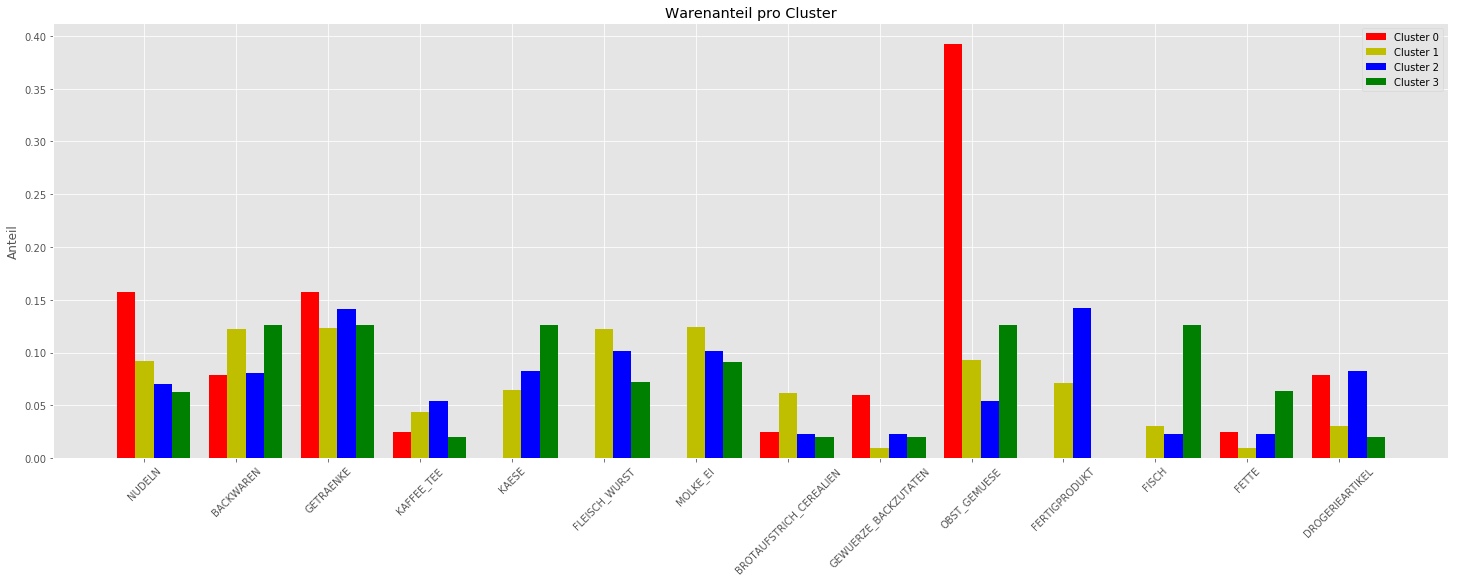

In [42]:
# TICKS ARE WRONG
# barplot with cluster centers
%matplotlib inline
plt.rcParams["figure.figsize"] = (25, 8)
centers
ind = np.arange(14)  # the x locations for the groups
width = 0.2   
fig, ax = plt.subplots()
rects1 = ax.bar(ind, (centers[0][0:14]), width, color='r')
rects2 = ax.bar(ind + width, (centers[1][0:14]), width, color='y')
rects3 = ax.bar(ind + 2*width, (centers[2][0:14]), width, color='b')
rects4 = ax.bar(ind + 3*width, (centers[3][0:14]), width, color='g')

ax.set_ylabel('Anteil')
ax.set_title('Warenanteil pro Cluster')
ax.set_xticks(ind + width)
#ax.set_xticklabels(("Obst_Gemuese","Fisch","Kaffee & Tee","Fleisch & Wurst","Drogerie","Gewuerze","Molke & Ei", \
#                 "Brotaufstrich","Backwaren","Nudeln","Getraenke","Kaese","Fette","Fertigprodukte"))

#ax.set_xticklabels(categoryList, rotation="vertical")
ax.set_xticklabels(categoryList, rotation=45)
#ax.set_xticks()

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'))


plt.show()

# 

In [43]:
# total revenue
total_revenue = predictions.agg(F.sum('total_price')).rdd.flatMap(lambda x: x).collect()[0]

# revenue per cluster
predictions.groupBy('cluster').agg(F.count('*').alias('number_of_customers'),
                                   (F.sum('total_price')/total_revenue).alias('revenue_per_cluster')).show()

+-------+-------------------+-------------------+
|cluster|number_of_customers|revenue_per_cluster|
+-------+-------------------+-------------------+
|      1|               2574| 0.6514279272101497|
|      3|               2450|0.14623036676689274|
|      2|               2476|0.12302183326485797|
|      0|               2500|0.07931987275809968|
+-------+-------------------+-------------------+



### Adding user Information

In [44]:
user_df = spark.read.json('kassenbons/user.json')

In [45]:
df = predictions.join(user_df.withColumnRenamed('Id', 'customerId'), on='customerId')

In [46]:
df_pandas = df.select('customerId', 'age','cluster').toPandas()

In [47]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
customerId    10000 non-null object
age           10000 non-null int64
cluster       10000 non-null int32
dtypes: int32(1), int64(1), object(1)
memory usage: 195.4+ KB


In [48]:
import seaborn as sns

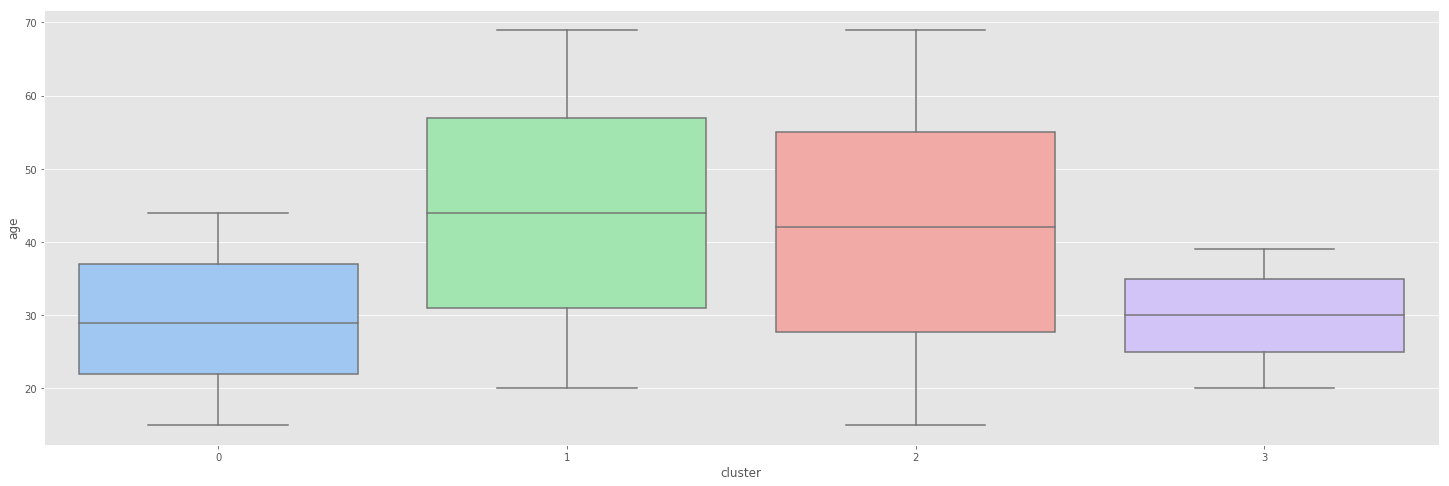

In [49]:
sns.boxplot(data=df_pandas, x='cluster', y='age')

### Silhouette Score and Cluster Evaluation (only spark 2.3)

In [50]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [51]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(predictionCol='cluster')

silhouette = evaluator.evaluate(df)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9870167403518258


In [ ]:
for element in range(2,6):
    # clustering model
    kmeans = KMeans(k=element, featuresCol="features", predictionCol="cluster")
    # build pipeline
    pipeline = Pipeline(stages=[categoryAssembler, sqlTrans, priceAssembler,
                            normalizer, scaler, assembler, kmeans])
    # fit model
    model = pipeline.fit(df)
    # make predictions
    predictions = model.transform(df)
    
    evaluator = ClusteringEvaluator(predictionCol='cluster')

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))